In [55]:
# clean old dirc
%cd ..
!rm -r LSTM-stock-predict
!rm LSTM-stock-predict.zip
!rm -r __MACOSX
!ls

/content
sample_data


In [56]:
# after uploading
!unzip LSTM-stock-predict.zip
%cd LSTM-stock-predict

Archive:  LSTM-stock-predict.zip
   creating: LSTM-stock-predict/
  inflating: LSTM-stock-predict/run.py  
   creating: __MACOSX/
   creating: __MACOSX/LSTM-stock-predict/
  inflating: __MACOSX/LSTM-stock-predict/._run.py  
   creating: LSTM-stock-predict/core/
  inflating: LSTM-stock-predict/core/data_processor.py  
   creating: __MACOSX/LSTM-stock-predict/core/
  inflating: __MACOSX/LSTM-stock-predict/core/._data_processor.py  
  inflating: LSTM-stock-predict/core/__init__.py  
  inflating: __MACOSX/LSTM-stock-predict/core/.___init__.py  
   creating: LSTM-stock-predict/core/__pycache__/
  inflating: LSTM-stock-predict/core/__pycache__/model.cpython-36.pyc  
  inflating: LSTM-stock-predict/core/__pycache__/data_processor.cpython-36.pyc  
  inflating: LSTM-stock-predict/core/__pycache__/utils.cpython-36.pyc  
  inflating: LSTM-stock-predict/core/__pycache__/__init__.cpython-36.pyc  
  inflating: LSTM-stock-predict/core/model.py  
  inflating: __MACOSX/LSTM-stock-predict/core/._model.p

[Model] Model Compiled
Time taken: 0:00:00.757342
[Model] Training Started
[Model] 15 epochs, 32 batch size, 124 batches per epoch
Epoch 1/15
124/124 [==============================] - 40s 322ms/step - loss: 0.0019
Epoch 2/15
124/124 [==============================] - 35s 279ms/step - loss: 6.8193e-04
Epoch 3/15
124/124 [==============================] - 34s 278ms/step - loss: 5.6667e-04
Epoch 4/15
124/124 [==============================] - 34s 278ms/step - loss: 5.6244e-04
Epoch 5/15
124/124 [==============================] - 34s 278ms/step - loss: 4.4890e-04
Epoch 6/15
124/124 [==============================] - 34s 277ms/step - loss: 4.0028e-04
Epoch 7/15
124/124 [==============================] - 34s 277ms/step - loss: 3.5379e-04
Epoch 8/15
124/124 [==============================] - 34s 278ms/step - loss: 3.6422e-04
Epoch 9/15
124/124 [==============================] - 35s 279ms/step - loss: 3.0629e-04
Epoch 10/15
124/124 [==============================] - 34s 278ms/step - loss: 3.0

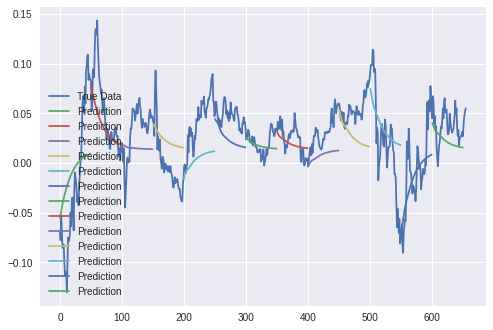

In [57]:
import os
import json
import time
import math
import matplotlib.pyplot as plt
import pickle
from core.data_processor import DataLoader
from core.model import Model
from sklearn.metrics import r2_score


def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()


def plot_results_multiple(predicted_data, true_data, prediction_len):
    print("plotting...")
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
	# Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()


configs = json.load(open('config.json', 'r'))
if not os.path.exists(configs['model']['save_dir']): os.makedirs(configs['model']['save_dir'])

data = DataLoader(
    os.path.join('data', configs['data']['filename']),
    configs['data']['train_test_split'],
    configs['data']['columns']
)

model = Model()
model.build_model(configs)
x, y = data.get_train_data(
    seq_len=configs['data']['sequence_length'],
    normalise=configs['data']['normalise']
)

'''
# in-memory training
model.train(
		x,
		y,
		epochs = configs['training']['epochs'],
		batch_size = configs['training']['batch_size'],
		save_dir = configs['model']['save_dir']
)
'''
# out-of memory generative training
steps_per_epoch = math.ceil((data.len_train - configs['data']['sequence_length']) / configs['training']['batch_size'])
model.train_generator(
    data_gen=data.generate_train_batch(
        seq_len=configs['data']['sequence_length'],
        batch_size=configs['training']['batch_size'],
        normalise=configs['data']['normalise']
    ),
    epochs=configs['training']['epochs'],
    batch_size=configs['training']['batch_size'],
    steps_per_epoch=steps_per_epoch,
    save_dir=configs['model']['save_dir']
)

x_test, y_test = data.get_test_data(
    seq_len=configs['data']['sequence_length'],
    normalise=configs['data']['normalise']
)

predictions = model.predict_sequences_multiple(x_test, configs['data']['sequence_length'], configs['data']['sequence_length'])
# predictions = model.predict_sequence_full(x_test, configs['data']['sequence_length'])
# predictions = model.predict_point_by_point(x_test)

plot_results_multiple(predictions, y_test, configs['data']['sequence_length'])
# plot_results(predictions, y_test)

# Save model
pickle.dump(model, open("model_v1.pkl", 'wb'))
#print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, predictions)))
#model.evaluate(x_test, y_test)
    
    


plotting!!!


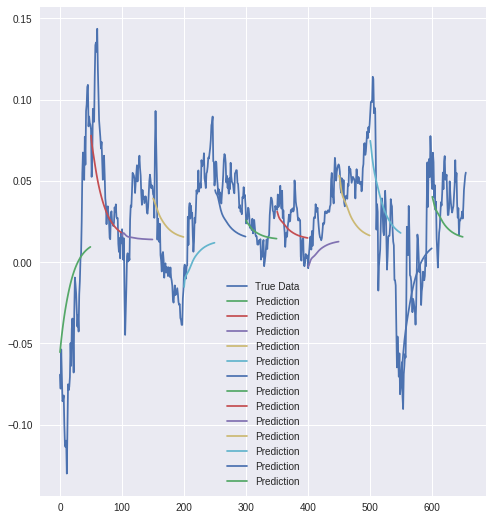

plotting!!!


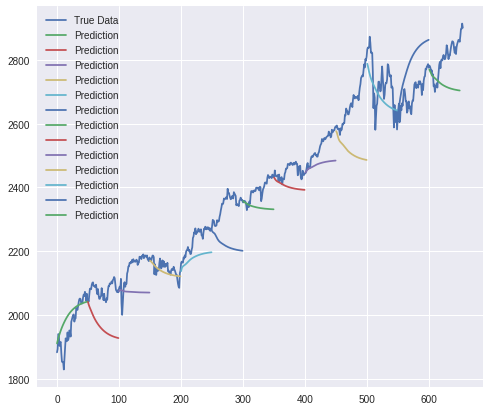

In [69]:
import numpy as np
def denormalise_windows(original_data, window_data, single_window=False):
  '''De-Normalise windows'''
  denormalised_data = []  
  window_data = np.array(window_data).astype(float)
  
  window_data = [window_data] if single_window else window_data
  for i, window in enumerate(window_data):
    denormalised_window = []
    p0 = original_data[i*50][0]
    for col_i in window:
      denormalised_col = (col_i+1) * p0
      denormalised_window.append(denormalised_col)
    denormalised_data.append(denormalised_window)
  return denormalised_data

def plot_results_multiple2(predicted_data, true_data, prediction_len, height, width):
    print("plotting!!!")
    fig = plt.figure(figsize=(8, width), facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
	# Pad the list of predictions to shift it in the graph to it's correct start
    
    for i, d in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + d, label='Prediction')
        plt.legend()
    plt.show()

  
x_test_true, y_test_true =data.get_test_data(
    seq_len=configs['data']['sequence_length'],
    normalise=False
)

predictions_true = denormalise_windows(data.data_test, predictions, False)
#print(len(data.data_test))

plot_results_multiple2(predictions, y_test, configs['data']['sequence_length'], 5, 9)

plot_results_multiple2(predictions_true, y_test_true, configs['data']['sequence_length'], 8, 7)

In [72]:
#model.evaluate(x_test, y_test)
#print([method_name for method_name in dir(model)
                  #if callable(getattr(model, method_name))])
#data.yo()
print(len(y_test_true))
sigma = 0
for i in range(650):
  sigma += (y_test_true[i][0] - predictions_true[i//50][i%50]) ** 2
test_loss = model.model.evaluate(x_test, y_test)
print("test loss :", test_loss)
print("denormalized test mse loss:", sigma/650)



655
655/655 [==============================] - 2s 3ms/step
test loss : 7.722326068923887e-05
denormalized test mse loss: 8849.338769752494
